In [91]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device:', device)

Using device: cuda


# Customized Dropout Algorithm Implementation

In [93]:
class CustomDropout(nn.Module):
    def __init__(self, p=0.5):
        super(CustomDropout, self).__init__()
        if p < 0 or p > 1:
            raise ValueError("Dropout probability has to be between 0 and 1, but got {}".format(p))
        self.p = p

    def forward(self, x):
        if self.training:
            # Create a mask with the same size as the input whose elements are drawn from Bernoulli distribution
            mask = torch.bernoulli(torch.ones_like(x) * (1 - self.p))
            return x * mask # Element-wise product between the input and the mask
        return x


In [94]:
# Load and preprocess MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(len(mnist_data) * (5/6))
validation_size = len(mnist_data) - train_size
train_data, validation_data = random_split(mnist_data, [train_size, validation_size])
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)


In [96]:
# Fully connected network with 2 hidden layers, each with 800 neurons
class NonDropoutModel(nn.Module):
    def __init__(self):
        super(NonDropoutModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=1)


In [97]:

class DropoutModel(nn.Module):
    def __init__(self, p=0.5):
        super(DropoutModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 1024)
        self.dropout1 = CustomDropout(p)    # Instantiate the CustomDropout module
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = CustomDropout(p)
        self.fc3 = nn.Linear(1024, 1024)
        self.dropout3 = CustomDropout(p)
        self.fc4 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout3(x)
        return self.fc4(x)



In [99]:
def train_model(model, optimizer, train_loader, validation_loader, epochs=50):
    model.train()
    criterion = nn.CrossEntropyLoss()
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Get accuracy on traiining set
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append(correct / total)

        # Validation set accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc.append(correct / total)
        print(f"Train Accuracy: {train_acc[-1]:.4f}, Validation Accuracy: {val_acc[-1]:.4f}")

    return train_acc, val_acc


In [100]:
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total


In [ ]:
# Initialize models
NonDropout = NonDropoutModel().to(device)
dropout = DropoutModel().to(device)

# Define optimizers
optimizer_NonDropout = optim.SGD(NonDropout.parameters(), lr=0.01, momentum=0.95)
optimizer_dropout = optim.SGD(dropout.parameters(), lr=0.01, momentum=0.95)

num_epochsMc = 60

# Train models
print("Training NonDropout Model")
train_acc_NonDropout, val_acc_NonDropout = train_model(NonDropout, optimizer_NonDropout, train_loader, validation_loader, epochs=num_epochsMc)
print("Training Dropout Model")
train_acc_dropout, val_acc_dropout = train_model(dropout, optimizer_dropout, train_loader, validation_loader, epochs=num_epochsMc)

# Get test set accuracy
test_accuracy_NonDropout = evaluate_model(NonDropout, test_loader)
test_accuracy_dropout = evaluate_model(dropout, test_loader)



In [108]:
print("NonDropout Model Test Accuracy:", test_accuracy_NonDropout)
print("Dropout Model Test Accuracy:", test_accuracy_dropout)

NonDropout Model Test Accuracy: 0.9721
Dropout Model Test Accuracy: 0.9782


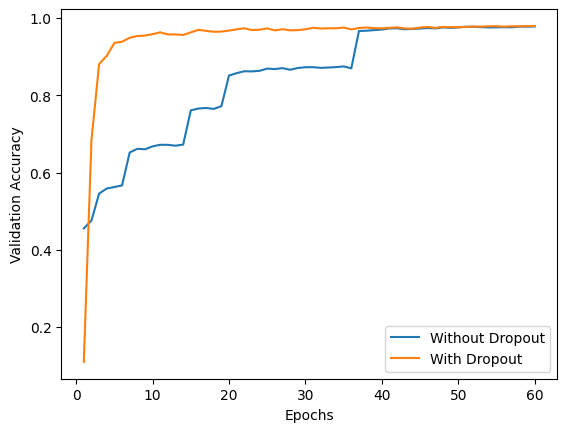

In [133]:
# Plot accuracy on validation set of both models
epochs = range(1, num_epochsMc+1)
plt.plot(epochs, val_acc_NonDropout, label='Without Dropout')
plt.plot(epochs, val_acc_dropout, label='With Dropout')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()
epochs = range(1, num_epochsMc + 1)


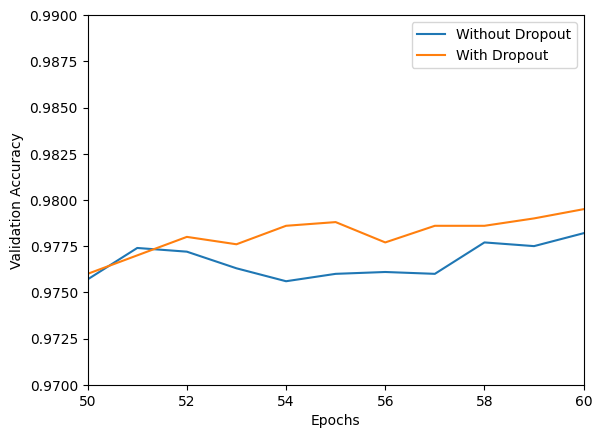

In [136]:
# Zoom in on the last 10 epochs
plt.plot(epochs, val_acc_NonDropout, label='Without Dropout')
plt.plot(epochs, val_acc_dropout, label='With Dropout')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.xlim(50, 60)
plt.ylim(0.97, 0.99)

plt.show()

# Impact Of Dropout On Different Datasets
#### Using PyTorch dropout function to ensure consistency

## MNIST

In [21]:
# Load and preprocess MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(len(mnist_data) * (5/6))
validation_size = len(mnist_data) - train_size
train_data, validation_data = random_split(mnist_data, [train_size, validation_size])
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

# Define the fully connected network with 2 hidden layers, each with 800 neurons
class NonDropoutModel(nn.Module):
    def __init__(self):
        super(NonDropoutModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=1)

class DropoutModel(nn.Module):
    def __init__(self):
        super(DropoutModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 1024)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 1024)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout3(x)
        return self.fc4(x)

# Initialize models
NonDropout = NonDropoutModel().to(device)
dropout = DropoutModel().to(device)

# Define optimizers
criterion = nn.CrossEntropyLoss()
optimizer_NonDropout = optim.SGD(NonDropout.parameters(), lr=0.01, momentum=0.95)
optimizer_dropout = optim.SGD(dropout.parameters(), lr=0.01, momentum=0.95)

num_epochsM = 60
# Training function
def train_model(model, optimizer, epochs=num_epochsM):
    model.train()
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Training set accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append(correct / total)

        # Validation set accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc.append(correct / total)

    return train_acc, val_acc

# Train models
print("Training NonDropout Model")
train_acc_NonDropout, val_acc_NonDropout = train_model(NonDropout, optimizer_NonDropout)
print("Training Dropout Model")
train_acc_dropout, val_acc_dropout = train_model(dropout, optimizer_dropout)

# Evaluate the models
def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

test_accuracy_NonDropout = evaluate_model(NonDropout)
test_accuracy_dropout = evaluate_model(dropout)

print("NonDropout Model Test Accuracy:", test_accuracy_NonDropout)
print("Dropout Model Test Accuracy:", test_accuracy_dropout)


Training NonDropout Model


Training Dropout Model


NonDropout Model Test Accuracy: 0.978
Dropout Model Test Accuracy: 0.9837


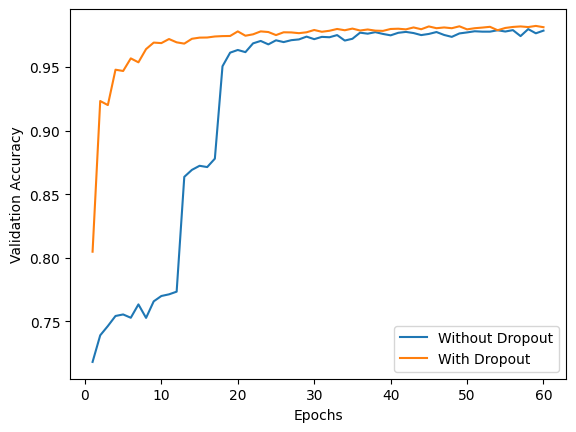

In [23]:
epochs = range(1, num_epochsM+1)

plt.plot(epochs, val_acc_NonDropout, label='Without Dropout')
plt.plot(epochs, val_acc_dropout, label='With Dropout')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

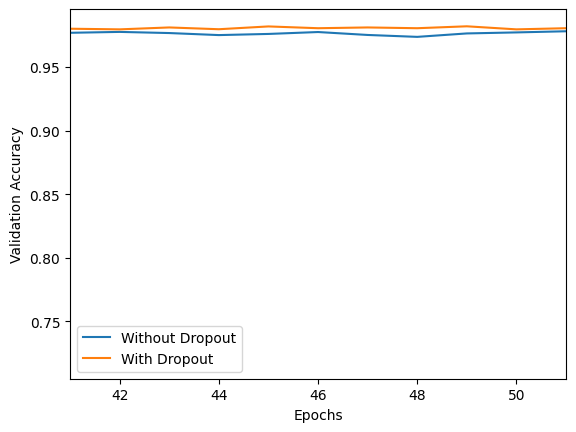

In [24]:
epochs = range(1, num_epochsM + 1)


plt.plot(epochs, val_acc_NonDropout, label='Without Dropout')
plt.plot(epochs, val_acc_dropout, label='With Dropout')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

plt.xlim(41, 51)

plt.show()

## SVHN (Street View House Numbers)

In [ ]:
# Load and preprocess the SVHN dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_data = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Split the train data into train and validation sets
train_size = int(0.8 * len(train_data))
validation_size = len(train_data) - train_size
train_dataset, validation_dataset = random_split(train_data, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

# Define the CNN model with dropout
class CNNWithDropout(nn.Module):
    def __init__(self):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 5, padding=2)
        self.pool = nn.MaxPool2d(3, 2, padding=1)
        self.conv2 = nn.Conv2d(96, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

# Define the CNN model without dropout
class CNNWithoutDropout(CNNWithDropout):
    def __init__(self):
        super(CNNWithoutDropout, self).__init__()
        self.dropout = nn.Dropout(0)

# Instantiate the models
model_with_dropout = CNNWithDropout().to(device)
model_without_dropout = CNNWithoutDropout().to(device)

# Define optimizer
criterion = nn.CrossEntropyLoss()
optimizer_with_dropout = optim.SGD(model_with_dropout.parameters(), lr=0.0001, momentum=0.95)
optimizer_without_dropout = optim.SGD(model_without_dropout.parameters(), lr=0.0001, momentum=0.95)

def train_model(model, optimizer, train_loader, validation_loader, epochs=5):
    model.train()
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for data in train_loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Training set accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        train_acc.append(train_accuracy)

        # Validation set accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in validation_loader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        validation_accuracy = 100 * correct / total
        val_acc.append(validation_accuracy)

        print(f'Epoch {epoch+1} - Train Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {validation_accuracy:.2f}%')

    print('Finished Training')
    return train_acc, val_acc

numEpochS = 40

print("Training Model with Dropout")
train_acc_dropout, val_acc_dropout = train_model(model_with_dropout, optimizer_with_dropout, train_loader, validation_loader, epochs=numEpochS)

print("\nTraining Model without Dropout")
train_acc_no_dropout, val_acc_no_dropout = train_model(model_without_dropout, optimizer_without_dropout, train_loader, validation_loader, epochs=numEpochS)

# Store the results
svhnM0 = model_without_dropout
svhnM5 = model_with_dropout
svhnT0 = train_acc_no_dropout
svhnT5 = train_acc_dropout
svhnV0 = val_acc_no_dropout
svhnV5 = val_acc_dropout
# Plotting accuracy graphs
epochs = range(1, numEpochS+1)
plt.plot(epochs, val_acc_dropout, 'b', label='With dropout')
plt.plot(epochs, val_acc_no_dropout, 'r', label='Without dropout')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Get test set accuracy
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

test_accuracy_dropout = evaluate_model(model_with_dropout, test_loader)
test_accuracy_no_dropout = evaluate_model(model_without_dropout, test_loader)


In [79]:
print("Test Accuracy with Dropout:", test_accuracy_dropout)
print("Test Accuracy without Dropout:", test_accuracy_no_dropout)

Test Accuracy with Dropout: 93.09695759065765
Test Accuracy without Dropout: 92.15457897971727


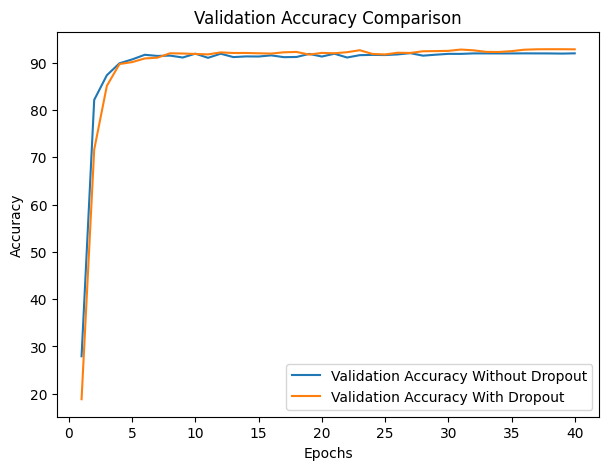

In [81]:
# Plot validation set accuracies
plt.figure(figsize=(7, 5))

plt.plot(range(1, numEpochS+1), val_acc_no_dropout, label='Validation Accuracy Without Dropout')
plt.plot(range(1, numEpochS+1), val_acc_dropout, label='Validation Accuracy With Dropout')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


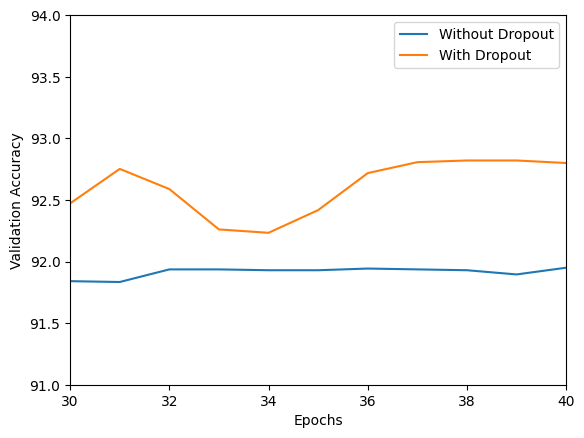

In [82]:
plt.plot(epochs, val_acc_no_dropout, label='Without Dropout')
plt.plot(epochs, val_acc_dropout, label='With Dropout')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# Set the x-axis limits
plt.xlim(30, 40)

# Set the y-axis limits
plt.ylim(91, 94)

plt.show()

## CIFAR-10

In [28]:
def evaluate_model(model, loader):
    model.eval()
    running_corrects = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(loader.dataset)
    return accuracy.item()


In [29]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs=50):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    accuracies = []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        val_acc = evaluate_model(model, val_loader)
        accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

    return model, accuracies


In [30]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_set_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Split training set into training and validation sets
train_size = int(0.9 * len(train_set_full))
val_size = len(train_set_full) - train_size
train_set, val_set = random_split(train_set_full, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=4, shuffle=True)
val_loader = DataLoader(val_set, batch_size=4, shuffle=False)
test_loader = DataLoader(test_set, batch_size=4, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [31]:
D = 32 # Dimension of image, for CIFAR datasets, D = 32
kernel_size = 3 # Window size of CNN layers
padding = kernel_size // 2 # Padding of CNN layers, is half of kernel size taking floor
stride = 1 # Stride between windows of CNN layers
dropout_possibility = 0.5

# Output dimension of a convolutional layer is (D+2*padding-kernel_size)/stride + 1
for i in range(2):
    D = (D+2*padding-kernel_size)/stride + 1
    D = int(D)
# Dimension is halved after maxpooling, since kernel size is 2 for maxpooling layer used
D = int(D//2)   # Size halved after maxpooling layer
for i in range(2):
    D = (D+2*padding-kernel_size)/stride + 1
    D = int(D)

cnn_with_dropout = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=kernel_size, padding=padding),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=padding),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=padding),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=padding),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(int(64 * D * D), 512),
    nn.ReLU(),
    nn.Dropout(dropout_possibility),  # Dropout layer with a dropout rate of 0.5
    nn.Linear(512, 10)
)

cnn_without_dropout = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=kernel_size, padding=padding),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=kernel_size, padding=padding),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=padding),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel_size, padding=padding),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(int(64 * D * D), 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

In [32]:
optimizer_with_dropout = optim.SGD(cnn_with_dropout.parameters(), lr=0.0001, momentum=0.95)
optimizer_without_dropout = optim.SGD(cnn_without_dropout.parameters(), lr=0.0001, momentum=0.95)

criterion = nn.CrossEntropyLoss()

In [ ]:
nopC = 50

cnn_with_dropout, accuracies_with_dropout = train_model(cnn_with_dropout, optimizer_with_dropout, train_loader, val_loader, num_epochs=nopC)
cnn_without_dropout, accuracies_without_dropout = train_model(cnn_without_dropout, optimizer_without_dropout, train_loader, val_loader, num_epochs=nopC)

accuracy_with_dropout = evaluate_model(cnn_with_dropout, test_loader)
accuracy_without_dropout = evaluate_model(cnn_without_dropout, test_loader)


In [34]:
print(f"Model with dropout achieved a test accuracy of {accuracy_with_dropout:.4f}")
print(f"Model without dropout achieved a test accuracy of {accuracy_without_dropout:.4f}")

Model with dropout achieved a test accuracy of 0.8123
Model without dropout achieved a test accuracy of 0.8082


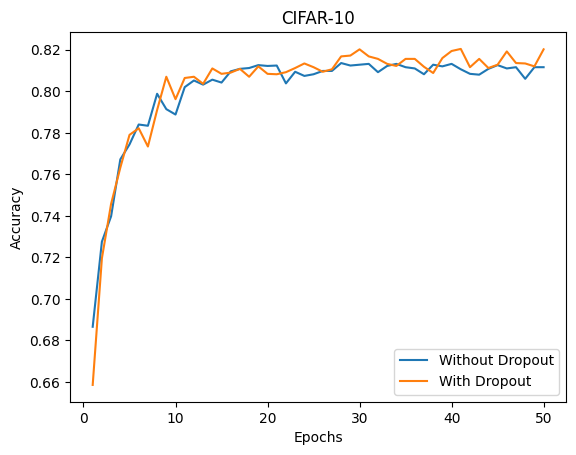

In [35]:
epochs = range(1, nopC + 1)

plt.plot(epochs, accuracies_without_dropout, label='Without Dropout')
plt.plot(epochs, accuracies_with_dropout, label='With Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CIFAR-10')
plt.legend()
plt.show()


## CIFAR-100

In [ ]:
# CIFAR-100
def evaluate_model(model, loader):
    model.eval()
    running_corrects = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(loader.dataset)
    return accuracy.item()

def train_model(model, optimizer, train_loader, val_loader, num_epochs=50):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    accuracies = []
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for i, (inputs, labels) in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        val_acc = evaluate_model(model, val_loader)
        accuracies.append(val_acc)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Acc: {val_acc:.4f}')

    return model, accuracies

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-100 dataset
train_set_full100 = datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_set100 = datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Split training set into training and validation sets
train_size100 = int(0.9 * len(train_set_full100))
val_size100 = len(train_set_full100) - train_size100
train_set100, val_set100 = random_split(train_set_full100, [train_size100, val_size100])

# Create data loaders
train_loader100 = DataLoader(train_set100, batch_size=4, shuffle=True)
val_loader100 = DataLoader(val_set100, batch_size=4, shuffle=False)
test_loader100 = DataLoader(test_set100, batch_size=4, shuffle=False)

D = 32 # Dimension of image, for CIFAR datasets, D = 32
kernel_size = 3 # Window size of CNN layers
padding = kernel_size // 2 # Padding of CNN layers, is half of kernel size taking floor
stride = 1 # Stride between windows of CNN layers
dropout_possibility = 0.5

# Output dimension of a convolutional layer is (D+2*padding-kernel_size)/stride + 1

D = (D+2*padding-kernel_size)/stride + 1
D = int(D)
# Dimension is halved after maxpooling, since kernel size is 2 for maxpooling layer used
D = int(D//2)   # Size halved after maxpooling layer

D = (D+2*padding-kernel_size)/stride + 1
D = int(D)
D = int(D//2)   # Size halved after maxpooling layer

D = (D+2*padding-kernel_size)/stride + 1
D = int(D)
D = int(D//2)

cnn100_with_dropout = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flattening the output for the fully connected layers
    nn.Flatten(),
    # Fully connected layers
    nn.Linear(in_features=128 * D * D, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Dropout(dropout_possibility),
    nn.Linear(in_features=512, out_features=100)
)

cnn100_without_dropout = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    # Flattening the output for the fully connected layers
    nn.Flatten(),
    # Fully connected layers
    nn.Linear(in_features=128 * D * D, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=100)
)
optimizer100_with_dropout = optim.SGD(cnn100_with_dropout.parameters(), lr=0.0001, momentum=0.95)
optimizer100_without_dropout = optim.SGD(cnn100_without_dropout.parameters(), lr=0.0001, momentum=0.95)

criterion = nn.CrossEntropyLoss()
nop100 = 50

cnn100_with_dropout, accuracies100_with_dropout = train_model(cnn100_with_dropout, optimizer100_with_dropout, train_loader100, val_loader100, num_epochs=nop100)
cnn100_without_dropout, accuracies100_without_dropout = train_model(cnn100_without_dropout, optimizer100_without_dropout, train_loader100, val_loader100, num_epochs=nop100)

accuracy100_with_dropout = evaluate_model(cnn100_with_dropout, test_loader100)
accuracy100_without_dropout = evaluate_model(cnn100_without_dropout, test_loader100)


In [ ]:
print(f"Model with dropout achieved a test accuracy of {accuracy100_with_dropout:.4f}")
print(f"Model without dropout achieved a test accuracy of {accuracy100_without_dropout:.4f}")

Model with dropout achieved a test accuracy of 0.4313
Model without dropout achieved a test accuracy of 0.4141


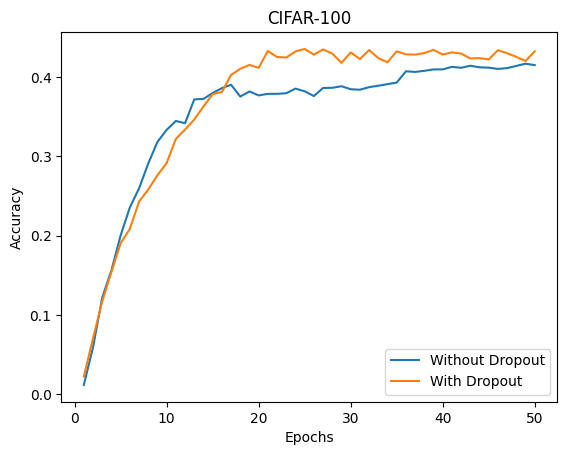

In [ ]:
epochs = range(1, nop100 + 1)
plt.plot(epochs, accuracies100_without_dropout, label='Without Dropout')
plt.plot(epochs, accuracies100_with_dropout, label='With Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CIFAR-100')
plt.legend()
plt.show()

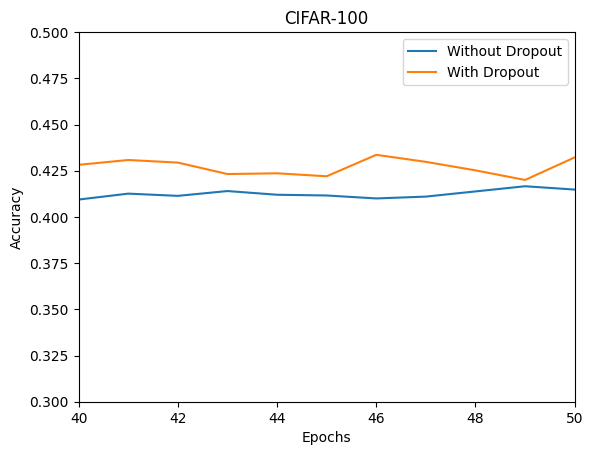

In [ ]:
epochs = range(1, nop100 + 1)
plt.plot(epochs, accuracies100_without_dropout, label='Without Dropout')
plt.plot(epochs, accuracies100_with_dropout, label='With Dropout')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CIFAR-100')
plt.legend()

plt.xlim(40, 50)
plt.ylim(0.3, 0.5)
plt.show()

## Test On Effect Of Different Hyperparameters

### MNIST (dropout = 0.1, 0.3, 0.5, 0.7, 0.9)

Training NonDropout Model


Training Dropout Model


Training model with dropout rate: 0.1


Test Accuracy for dropout rate 0.1: 0.9794
Training model with dropout rate: 0.3


Test Accuracy for dropout rate 0.3: 0.9809
Training model with dropout rate: 0.5


Test Accuracy for dropout rate 0.5: 0.9826
Training model with dropout rate: 0.7


Test Accuracy for dropout rate 0.7: 0.9709
Training model with dropout rate: 0.9


Test Accuracy for dropout rate 0.9: 0.1135


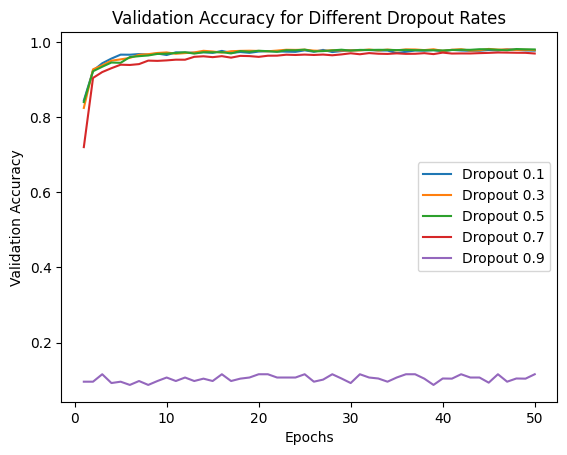

In [44]:
# Load and preprocess MNIST data
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(len(mnist_data) * (5/6))
validation_size = len(mnist_data) - train_size
train_data, validation_data = random_split(mnist_data, [train_size, validation_size])
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
validation_loader = DataLoader(validation_data, batch_size=8, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

# Define the models
class NonDropoutModel(nn.Module):
    def __init__(self):
        super(NonDropoutModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 800)
        self.fc2 = nn.Linear(800, 800)
        self.fc3 = nn.Linear(800, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=1)

# Modified Dropout Model
dropout_rate = 0.5
class DropoutModel(nn.Module):
    def __init__(self, dropout_rate):
        super(DropoutModel, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 1024)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(1024, 1024)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.fc4 = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout1(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout2(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.dropout3(x)
        return self.fc4(x)


# Initialize models
NonDropout = NonDropoutModel().to(device)
dropout = DropoutModel(dropout_rate).to(device)

# Loss function and optimizers
criterion = nn.CrossEntropyLoss()
optimizer_NonDropout = optim.SGD(NonDropout.parameters(), lr=0.01, momentum=0.95)
optimizer_dropout = optim.SGD(dropout.parameters(), lr=0.01, momentum=0.95)

num_epochsMp = 50

def train_model(model, optimizer, epochs=num_epochsMp):
    model.train()
    train_acc, val_acc = [], []
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Training set accuracy
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc.append(correct / total)

        # Validation set accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc.append(correct / total)

    return train_acc, val_acc

print("Training NonDropout Model")
train_acc_NonDropout, val_acc_NonDropout = train_model(NonDropout, optimizer_NonDropout)
print("Training Dropout Model")
train_acc_dropout, val_acc_dropout = train_model(dropout, optimizer_dropout)

def evaluate_model(model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            outputs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# Dictionary to store validation accuracies
val_acc_dict = {}

# Train with different dropout rates
dropout_rates = [0.1, 0.3, 0.5, 0.7, 0.9]
for rate in dropout_rates:
    print(f"Training model with dropout rate: {rate}")
    model = DropoutModel(dropout_rate=rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.95)
    train_acc, val_acc = train_model(model, optimizer)
    val_acc_dict[rate] = val_acc  # Store validation set accuracy
    test_accuracy = evaluate_model(model)
    print(f"Test Accuracy for dropout rate {rate}: {test_accuracy}")

# Plotting the validation accuracies for different dropout rates
epochs = range(1, num_epochsMp+1)
for rate, acc in val_acc_dict.items():
    plt.plot(epochs, acc, label=f'Dropout {rate}')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Dropout Rates')
plt.legend()
plt.show()


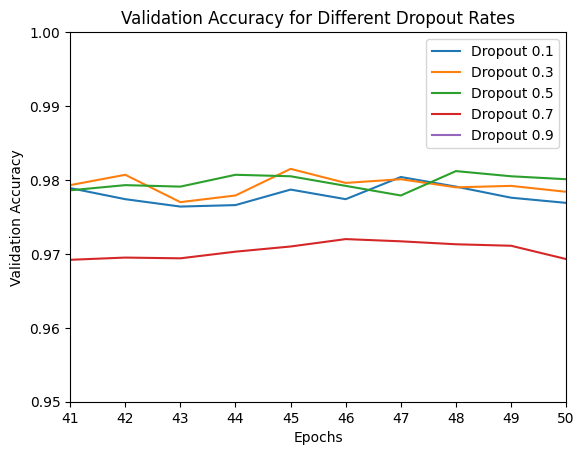

In [46]:
# Plot the validation set accuracies for different dropout rates
epochs = range(1, num_epochsMp+1)
for rate, acc in val_acc_dict.items():
    plt.plot(epochs, acc, label=f'Dropout {rate}')

plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy for Different Dropout Rates')
plt.legend()
plt.xlim(41, 50)
plt.ylim(0.95, 1)
plt.show()


### SVHN (dropout = 0, 0.1, 0.3, 0.5, 0.7, 0.9)

In [58]:
# Load and preprocess the SVHN dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_data = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Split the train data into train and validation sets
train_size = int(0.8 * len(train_data))
validation_size = len(train_data) - train_size
train_dataset, validation_dataset = random_split(train_data, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_data, batch_size=4, shuffle=False)

# Define the CNN model with variable dropout
class CNNWithDropout(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(CNNWithDropout, self).__init__()
        self.conv1 = nn.Conv2d(3, 96, 5, padding=2)
        self.pool = nn.MaxPool2d(3, 2, padding=1)
        self.conv2 = nn.Conv2d(96, 128, 5, padding=2)
        self.conv3 = nn.Conv2d(128, 256, 5, padding=2)
        self.fc1 = nn.Linear(256 * 4 * 4, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 10)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = x.view(-1, 256 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
numEpochS = 30
# Instantiate and train models with different dropout rates
dropout_rates = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

models = []
for rate in dropout_rates:
    model = CNNWithDropout(dropout_rate=rate).to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.95)
    print(f"Training Model with Dropout Rate: {rate}")
    train_acc, val_acc = train_model(model, optimizer, train_loader, validation_loader, epochs=numEpochS)
    models.append((model, train_acc, val_acc))

# Get test set accuracy for each model
for model, _, _ in models:
    test_accuracy = evaluate_model(model, test_loader)
    print(f"Test Accuracy with Dropout Rate {model.dropout.p}: {test_accuracy}%")

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Training Model with Dropout Rate: 0
Epoch 1 - Train Accuracy: 22.63%, Validation Accuracy: 46.42%
Epoch 2 - Train Accuracy: 72.42%, Validation Accuracy: 85.39%
Epoch 3 - Train Accuracy: 87.11%, Validation Accuracy: 88.94%
Epoch 4 - Train Accuracy: 90.30%, Validation Accuracy: 89.86%
Epoch 5 - Train Accuracy: 92.01%, Validation Accuracy: 91.54%
Epoch 6 - Train Accuracy: 93.28%, Validation Accuracy: 92.47%
Epoch 7 - Train Accuracy: 94.45%, Validation Accuracy: 92.30%
Epoch 8 - Train Accuracy: 95.17%, Validation Accuracy: 92.51%
Epoch 9 - Train Accuracy: 96.01%, Validation Accuracy: 92.19%
Epoch 10 - Train Accuracy: 96.68%, Validation Accuracy: 92.90%
Epoch 11 - Train Accuracy: 97.31%, Validation Accuracy: 92.70%
Epoch 12 - Train Accuracy: 97.86%, Validation Accuracy: 92.96%
Epoch 13 - Train Accuracy: 98.36%, Validation Accuracy: 92.09%
Epoch 14 - Train Accuracy: 98.58%, Va

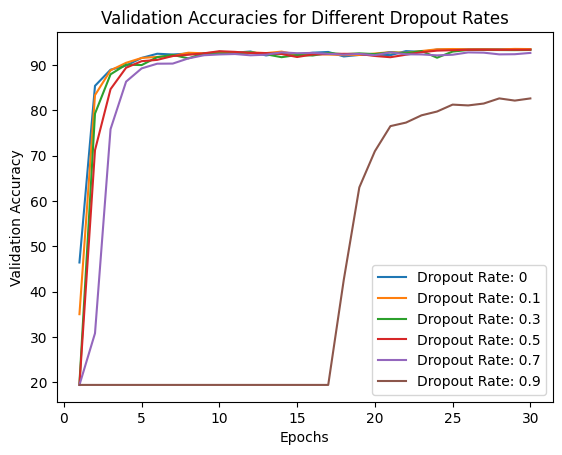

In [59]:
epochs = range(1, numEpochS + 1)

for model, train_acc, val_acc in models:
    dropout_rate = model.dropout.p
    plt.plot(epochs, val_acc, label=f'Dropout Rate: {dropout_rate}')

plt.title('Validation Accuracies for Different Dropout Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.show()

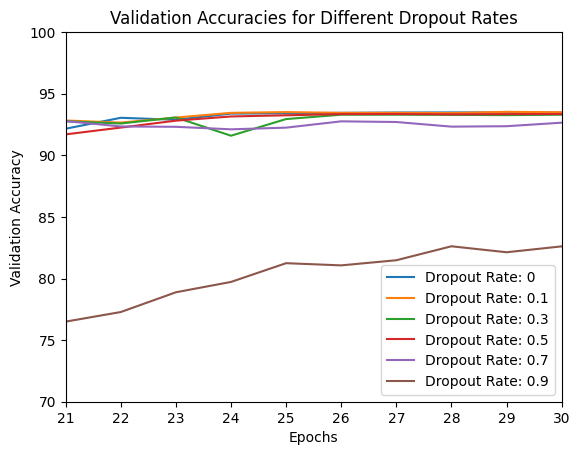

In [63]:
epochs = range(1, numEpochS + 1)

for model, train_acc, val_acc in models:
    dropout_rate = model.dropout.p
    plt.plot(epochs, val_acc, label=f'Dropout Rate: {dropout_rate}')

plt.title('Validation Accuracies for Different Dropout Rates')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.xlim(21, 30)
plt.ylim(70, 100)
plt.show()